In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix


import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding,Dense,GRU, Bidirectional, LSTM, Flatten, GlobalAveragePooling1D, Dropout, InputLayer, Input

from gensim.models import word2vec, keyedvectors
import gensim

from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining classes
classes = {
    'fake' : 0,
    'hate' : 1,
    'safe' : 2
}

In [ ]:
final_data = pd.read_csv('./data/final_data_v2.csv')

In [ ]:
# Defining X and y, X is being title of the news and type being label
X = final_data['title']
final_data['type'] = final_data['type'].apply(lambda x: classes[x])
y = final_data['type']


# Class counts
y.value_counts()

1    76495
0    76495
2    21417
Name: type, dtype: int64

In [ ]:
# Splitting dataset into train and test set
test_size = 0.20
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = test_size)

In [ ]:
def avg_sentence_vector(sentence, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    words = sentence.split()
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        word = word.lower()
        if word in index2word_set:
            nwords = nwords+1
            featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec



In [ ]:
def get_glove_embeddings(d):
  embeddings_index = {}
  f = open('./glove/glove.6B.'+str(d)+'d.txt')
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = vector
  f.close()
  return embeddings_index

def print_dash():
  print("\n-----------------------------------------------------\n")

In [ ]:
# Feature Extraction / Word Embeddings from the sentences
def get_doc_vector(X_train, X_test, v_type="glove", c_type="svm"):
  # supported v_type : glove, word2vec, tfidf, bow(bag of words), hv(hashing vectorizer)
  try:

    if v_type == "glove":
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(X_train.astype(str))
      vocab = tokenizer.word_index
      encodings_train = tokenizer.texts_to_sequences(X_train.astype(str))
      max_length = 100
      padded_encodings_train = pad_sequences(encodings_train, maxlen=max_length, padding='post')
      encodings_test = tokenizer.texts_to_sequences(X_test.astype(str))
      padded_encodings_test = pad_sequences(encodings_test, maxlen=max_length, padding='post')
      embeddings_index = get_glove_embeddings(100)

      embedding_matrix = np.zeros((len(vocab) + 1, max_length))
      for word, i in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

      inp = Input((max_length))
      embedder = Embedding(len(vocab) + 1, max_length,
                          trainable=False, weights=[embedding_matrix])(inp)
      if c_type == 'lstm' or c_type == 'bilstm':
        model = Model(inp, embedder)
      else:
        avg = GlobalAveragePooling1D()(embedder)
        model = Model(inp, avg)
      
      X_train_new = model(padded_encodings_train).numpy()
      X_test_new = model(padded_encodings_test).numpy()
      return X_train_new, X_test_new
    
    elif v_type == "word2vec":
      vector_data=X_train.astype(str).apply(gensim.utils.simple_preprocess)
      model= gensim.models.Word2Vec(
              window=12,
              min_count=2,
              workers=4)
      model.build_vocab(vector_data,progress_per=1000)
      model.train(vector_data, total_examples=model.corpus_count,epochs=model.epochs)
      index2word_set = set(model.wv.index2word)
      X_train_new = X_train.apply(avg_sentence_vector, args=(model, 100, index2word_set))
      X_train_new = np.stack( X_train_new.to_numpy(), axis=0 )
      X_test_new = X_test.apply(avg_sentence_vector, args=(model, 100, index2word_set))
      X_test_new = np.stack( X_test_new.to_numpy(), axis=0 )
      return X_train_new, X_test_new
      

    elif v_type == "tfidf":
      tfidf_vec = TfidfVectorizer(max_features=300)
      tfidf_vec.fit(X_train)
      X_train_new = tfidf_vec.transform(X_train)
      X_test_new = tfidf_vec.transform(X_test)
      return X_train_new.toarray(), X_test_new.toarray()
    
    elif v_type == 'hv':
      # NOTE: only 400 features
      hashing_vec = HashingVectorizer(stop_words='english', alternate_sign=False, n_features=400)
      hashing_vec.fit(X_train)
      X_train_new = hashing_vec.transform(X_train)
      X_test_new = hashing_vec.transform(X_test)
      return X_train_new.toarray(), X_test_new.toarray()
    
    elif v_type == "bow":
      count_vec = CountVectorizer(ngram_range=(1,1), stop_words='english',max_features=300)
      count_vec.fit(X_train)
      X_train_new = count_vec.transform(X_train)
      X_test_new = count_vec.transform(X_test)
      return X_train_new.toarray(), X_test_new.toarray()
    
    else:
      raise ValueError('supported types are only : glove, word2vec, tfidf, bow')
      return False
  
  except Exception as error:
        print(repr(error))


In [ ]:
# Feature Extraction Type 
# change v_type variable:
# available options : glove, word2vec, tfidf, bow(bag of words), hv(hashing vectorizer)
v_type = "glove"

# Classification Type
# change c_type variable:
# available options : svm, lsvm(Linear SVM), nb(Naive Bayes), lr(Logistic Regression), pa(Passive Aggressive), xgboost, lstm, bilstm
c_type = "lr"

In [ ]:
X_train_new, X_test_new = get_doc_vector(X_train, X_test, v_type, c_type)
print('Vectors Generated :')
print(X_train_new.shape)

Vectors Generated :
(139525, 100)


In [ ]:
from imblearn.over_sampling import SMOTE
# Oversampling
# oversampling only if classifier is not lstm and not bilstm and also when feature extraction method isn't glove and isn't hv

if ((c_type == 'lstm' or c_type == 'bilstm') and v_type == 'glove') or v_type == 'hv':
  X_sm = X_train_new
  X_test_sm = X_test_new
  y_sm = y_train
  y_test_sm = y_test
else:
  smote = SMOTE(ratio='minority')
  X_sm, y_sm = smote.fit_sample(X_train_new, y_train)

  smote = SMOTE(ratio='minority')
  X_test_sm, y_test_sm = smote.fit_sample(X_test_new, y_test)

In [ ]:
def classifier(X_train, X_val,  X_test, y_train, y_val, y_test, c_type="svm", v_type="glove", epochs=20):
  if c_type == 'svm':
    print_dash()
    print("Running Linear SVM classifier...\n")
    clf_svm = make_pipeline(StandardScaler(with_mean=False), SVC())
    clf_svm.fit(X_train, y_train)  
    y_pred_svm=clf_svm.predict(X_test)
    print_dash()
    return y_pred_svm
  
  if c_type == 'lsvm':
    print_dash()
    print("Running SVM classifier...\n")
    clf_lsvm = make_pipeline(LinearSVC())
    clf_lsvm.fit(X_train, y_train)
    y_pred_lsvm=clf_lsvm.predict(X_test)
    print_dash()
    return y_pred_lsvm

  if c_type == 'nb':
    print_dash()
    print("Running Naive Bayes classifier...\n")
    clf_nb = make_pipeline(MinMaxScaler(), MultinomialNB())
    clf_nb.fit(X_train, y_train)
    y_pred_nb=clf_nb.predict(X_test)
    print_dash()
    return y_pred_nb

  
  if c_type == 'lr':
    print_dash()
    print("Running Logistic Regression classifier...\n")
    clf_lr = make_pipeline(StandardScaler(with_mean=False), LogisticRegression())
    clf_lr.fit(X_train, y_train)
    y_pred_lr=clf_lr.predict(X_test)
    print_dash()
    return y_pred_lr

  if c_type == 'pa':
    print_dash()
    print("Running Passive Aggressive classifier...\n")
    clf_pa = make_pipeline(PassiveAggressiveClassifier(max_iter=50, random_state=7))
    clf_pa.fit(X_train, y_train)
    y_pred_pa=clf_pa.predict(X_test)
    print_dash()
    return y_pred_pa

  if c_type == 'xgboost':
    print_dash()
    print("Running XGBoost classifier...\n")
    clf_xgb = make_pipeline(StandardScaler(with_mean=False), XGBClassifier(objective='multi:softmax',missing=None))
    clf_xgb.fit(X_train, y_train)
    y_pred_xgb=clf_xgb.predict(X_test)
    print_dash()
    return y_pred_xgb

  if c_type == 'lstm':
    print_dash()
    print("Running LSTM classifier...\n")
    if v_type != 'glove':
      X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[-1])
      X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[-1])
      X_val = X_val.reshape(X_val.shape[0],1,X_val.shape[-1])
    
    # Creating LSTM model
    model = Sequential()
    model.add(LSTM(units=64, return_sequences = True))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(100, activation='relu'))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=1024, epochs=epochs, validation_data=(X_val,y_val), verbose=1)
    y_pred_lstm = np.argmax(model.predict(X_test), axis=-1)
    print_dash()
    return y_pred_lstm



  if c_type == 'bilstm':
    print_dash()
    print("Running bidirectional LSTM classifier...\n")
    if v_type != 'glove':
      X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[-1])
      X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[-1])
      X_val = X_val.reshape(X_val.shape[0],1,X_val.shape[-1])

    # Creating bi-LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64,)))
    model.add(Dense(100, activation='relu'))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=1024, epochs=epochs, validation_data=(X_val,y_val), verbose=1)
    
    y_pred_bilstm = np.argmax(model.predict(X_test), axis=-1)
    print_dash()
    return y_pred_bilstm


In [ ]:
import warnings
warnings.filterwarnings("ignore")

X_train_new = None
X_test_new = None

X_sm_, X_val, y_sm_, y_val = train_test_split(X_sm, y_sm, test_size=0.25, random_state=1)
X_sm = None
y_sm = None


if (c_type == 'lstm' or c_type == 'bilstm'):
  y_sm_1 = tf.keras.utils.to_categorical(
      y_sm_, num_classes=3, dtype='float32'
  )
  y_test_sm_1 = tf.keras.utils.to_categorical(
      y_test_sm, num_classes=3, dtype='float32'
  )
  y_val_sm_1 = tf.keras.utils.to_categorical(
      y_val, num_classes=3, dtype='float32'
  )

  epochs = 25
  if (v_type == 'hv'):
    epochs = 80
  
  y_pred = classifier(X_sm_.astype('float32'),X_val.astype('float32'), X_test_sm.astype('float32'), y_sm_1, y_val_sm_1, y_test_sm_1, c_type, v_type, epochs=epochs)

else:
  y_pred = classifier(X_sm_, X_val, X_test_sm, y_sm_, y_val, y_test_sm, c_type, v_type)



-----------------------------------------------------

Running Logistic Regression classifier...


-----------------------------------------------------



In [ ]:
print("Classification : ",c_type)
print("Feature Extraction : ",v_type)
print_dash()

print(classification_report(y_test_sm, y_pred))

Classification :  lr
Feature Extraction :  glove

-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     15189
           1       0.73      0.68      0.70     15378
           2       0.83      0.86      0.84     15378

    accuracy                           0.75     45945
   macro avg       0.75      0.75      0.75     45945
weighted avg       0.75      0.75      0.75     45945



In [ ]:
cf_matrix = confusion_matrix(y_test_sm, y_pred)
print(cf_matrix)

[[10981  2754  1454]
 [ 3618 10402  1358]
 [ 1037  1043 13298]]


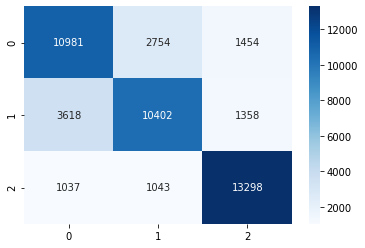

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')